In [90]:
# import numpy as np
# import pandas as pd
# import mysql.connector
# import os

# # List of CSV files and their corresponding table names
# csv_files = [
#     ('customers.csv', 'customers'),
#     ('orders.csv', 'orders'),
#     ('sellers.csv', 'sellers'),
#     ('products.csv', 'products'),
#     ('geolocation.csv', 'geolocation'),
#     ('payments.csv', 'payments'),  
#     ('order_items.csv','order_items')# Added payments.csv for specific handling
# ]

# # Connect to the MySQL database
# conn = mysql.connector.connect(
#     host='localhost',
#     user='root',
#     password='Tajhotel123@',
#     database='ecommerce'
# )
# cursor = conn.cursor()

# # Folder containing the CSV files
# folder_path = 'C:/Users/ASUS/OneDrive/Desktop/Ecommerce'

# def get_sql_type(dtype):
#     if pd.api.types.is_integer_dtype(dtype):
#         return 'INT'
#     elif pd.api.types.is_float_dtype(dtype):
#         return 'FLOAT'
#     elif pd.api.types.is_bool_dtype(dtype):
#         return 'BOOLEAN'
#     elif pd.api.types.is_datetime64_any_dtype(dtype):
#         return 'DATETIME'
#     else:
#         return 'TEXT'

# for csv_file, table_name in csv_files:
#     file_path = os.path.join(folder_path, csv_file)
    
#     # Read the CSV file into a pandas DataFrame
#     df = pd.read_csv(file_path)
    
#     # Replace NaN with None to handle SQL NULL
#     df = df.where(pd.notnull(df), None)
    
#     # Debugging: Check for NaN values
#     print(f"Processing {csv_file}")
#     print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

#     # Clean column names
#     df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

#     # Generate the CREATE TABLE statement with appropriate data types
#     columns = ', '.join([f'{col} {get_sql_type(df[col].dtype)}' for col in df.columns])
#     create_table_query = f'CREATE TABLE IF NOT EXISTS {table_name} ({columns})'
#     cursor.execute(create_table_query)

#     # Insert DataFrame data into the MySQL table
#     for _, row in df.iterrows():
#         # Convert row to tuple and handle NaN/None explicitly
#         values = tuple(None if pd.isna(x) else x for x in row)
#         sql = f"INSERT INTO {table_name} ({', '.join(['' + col + '' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
#         cursor.execute(sql, values)

#     # Commit the transaction for the current CSV file
#     conn.commit()

# # Close the connection

In [91]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost" , 
                             username = "root" , 
                             password = "Tajhotel123@" , 
                             database = "ecommerce")

cur = db.cursor()

 # List all unique cities where customers are located.

In [92]:
query = """ select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [93]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
'total orders placed in 2017 are', data[0][0]

('total orders placed in 2017 are', 135303)

# Find the total sales per category.

In [94]:
query = """select upper(products.product_category) category , 
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data , columns = ["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,13681943.82
1,FURNITURE DECORATION,38614762.58
2,TELEPHONY,13145815.37
3,BED TABLE BATH,46238949.12
4,AUTOMOTIVE,23011946.94
...,...,...
69,CDS MUSIC DVDS,32384.61
70,LA CUISINE,78665.31
71,FASHION CHILDREN'S CLOTHING,21213.09
72,PC GAMER,58709.61


# Calculate the percentage of orders that were paid in installments.

In [95]:
query = """ select (sum(case when payment_installments >= 1 then 1 
else 0 end))/count(*)*100 from payments

"""
cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments is",data[0][0]


('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

#  Count the number of customers from each state. 


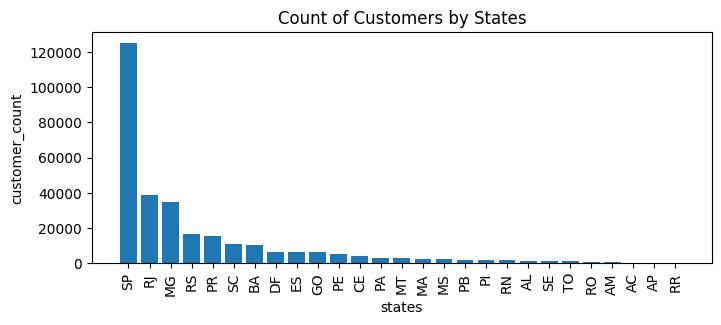

In [96]:
query = """ select customer_state , count(customer_id)
from customers group by customer_state
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["state" , "customer_count"])
df = df.sort_values(by = "customer_count",ascending= False)
plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90 )
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()


# Calculate the number of orders per month in 2018.


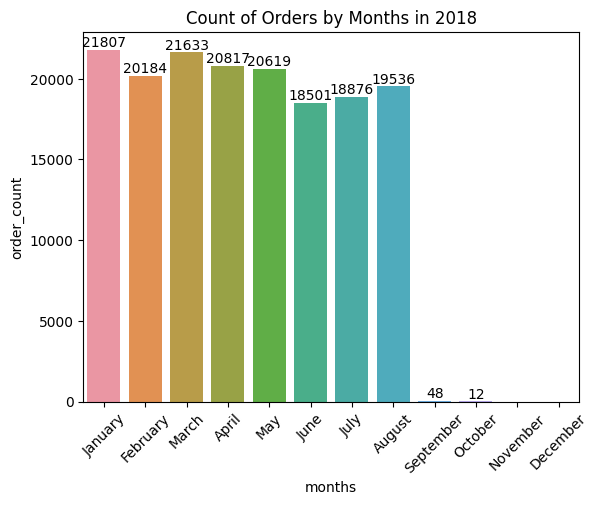

In [97]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id)
from orders where year(order_purchase_timestamp) = 2018
group by months
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns = ["months","order_count"])
o = ["January", "February", "March", "April", "May", "June" , "July", "August",
     "September","October","November","December"]
ax = sns.barplot(x = df["months"], y= df["order_count"], data = df, order=o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")
plt.show()


#  Find the average number of products per order, grouped by customer city.

In [98]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id)as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders desc
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns=["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,63.00
1,celso ramos,58.50
2,datas,54.00
3,candido godoi,54.00
4,matias olimpio,45.00
5,cidelandia,36.00
6,curralinho,36.00
7,picarra,36.00
8,morro de sao paulo,36.00
9,teixeira soares,36.00


# Calculate the percentage of total revenue contributed by each product category.

In [99]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,96.28
1,HEALTH BEAUTY,93.18
2,COMPUTER ACCESSORIES,89.13
3,FURNITURE DECORATION,80.40
4,WATCHES PRESENT,80.35


# Identify the correlation between product price and the number of times a product has been purchased.

In [100]:
cur = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][1])


the correlation is -0.10631514167157556


# Calculate the total revenue generated by each seller, and rank them by revenue.

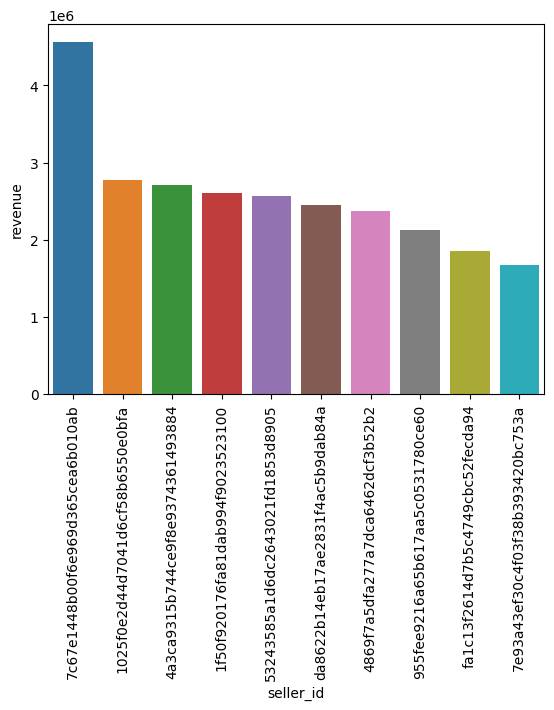

In [101]:
 query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head(10)
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [102]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
...,...,...,...,...
934969,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.37
934970,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.37
934971,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.37
934972,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.37


# Calculate the cumulative sales per month for each year.

In [103]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
pd.set_option('display.float_format', '{:.2f}'.format)

df

,0,1,2,3
0,2016,9,2270.16,2270.16
1,2016,10,531814.32,534084.48
2,2016,12,176.58,534261.06
3,2017,1,1246392.36,1780653.42
4,2017,2,2627172.09,4407825.51
5,2017,3,4048772.40,8456597.91
6,2017,4,3760092.27,12216690.18
7,2017,5,5336269.38,17552959.56
8,2017,6,4601487.42,22154446.98
9,2017,7,5331446.28,27485893.26


#  Calculate the year-over-year growth rate of total sales.

In [104]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.70
2,2018,20.00


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [105]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data 
# since none of our customers buy again in the interval of 6 months, 
# hence value is coming none

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

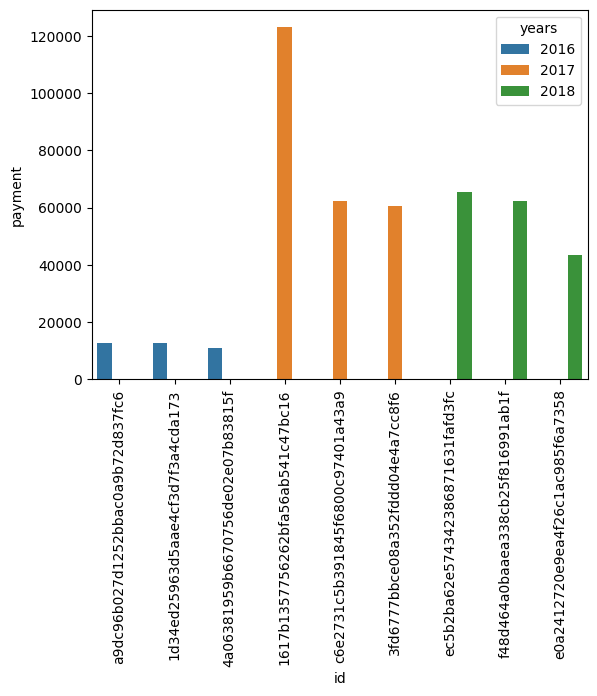

In [106]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()